In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [43]:
class TaskDataset(Dataset):
    def __init__(self, ids, imgs, labels, transform=None):
        self.ids = ids
        self.imgs = imgs
        self.labels = labels
        self.transform = transform


    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
            if img.shape[0] == 1:
                img = img.repeat(3, 1, 1)
        label = int(self.labels[index])
        return id_, img, label

    def __len__(self):
        return len(self.ids)


In [44]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = torch.load("./ModelStealingPub.pt")
ids = range(len(dataset.imgs))
dataset = TaskDataset(ids=ids, imgs=dataset.imgs, labels=dataset.labels, transform=transform)
public_dataset = DataLoader(dataset=dataset, batch_size=64, shuffle=True)


In [45]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.fc = nn.Linear(8 * 8 * 32, 64)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(-1, 8 * 8 * 32)
        x = self.fc(x)
        return x

In [47]:
encoder = Encoder()
optimizer = optim.Adam(encoder.parameters(), lr=0.001)

In [56]:
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (_,imgs, _) in enumerate(public_dataset):
        optimizer.zero_grad()
        output = encoder(imgs)
        dist_matrix = torch.cdist(output, output, p=2)
        true_similarity = torch.exp(-dist_matrix)
        true_similarity = true_similarity / torch.sum(true_similarity, dim=1, keepdim=True)
        soft_nearest_neighbors = F.softmax(-dist_matrix, dim=1)
        
        loss = torch.mean(torch.sum((true_similarity - soft_nearest_neighbors) ** 2, dim=1))        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss/len(public_dataset.dataset)}')

Epoch [1/10], Average Loss: 1.5760162397771098e-18
Epoch [2/10], Average Loss: 1.810558296525421e-18
Epoch [3/10], Average Loss: 1.6398018784197367e-18
Epoch [4/10], Average Loss: 1.64408775667487e-18
Epoch [5/10], Average Loss: 1.5330524303772254e-18
Epoch [6/10], Average Loss: 1.5543307159585027e-18
Epoch [7/10], Average Loss: 1.6098396396497115e-18
Epoch [8/10], Average Loss: 1.656817851159596e-18
Epoch [9/10], Average Loss: 1.7647044601216134e-18
Epoch [10/10], Average Loss: 1.7337255184956412e-18


In [57]:
embeddings = []
labels = []

for batch_idx, (_, imgs, label) in enumerate(public_dataset):
    embeddings.append(encoder(imgs).detach().numpy())
    labels.append(label.numpy())

embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

kmeans = KMeans(n_clusters=10, random_state=0)
cluster_ids = kmeans.fit_predict(embeddings)

In [58]:
print(cluster_ids)

[2 9 2 ... 1 6 1]


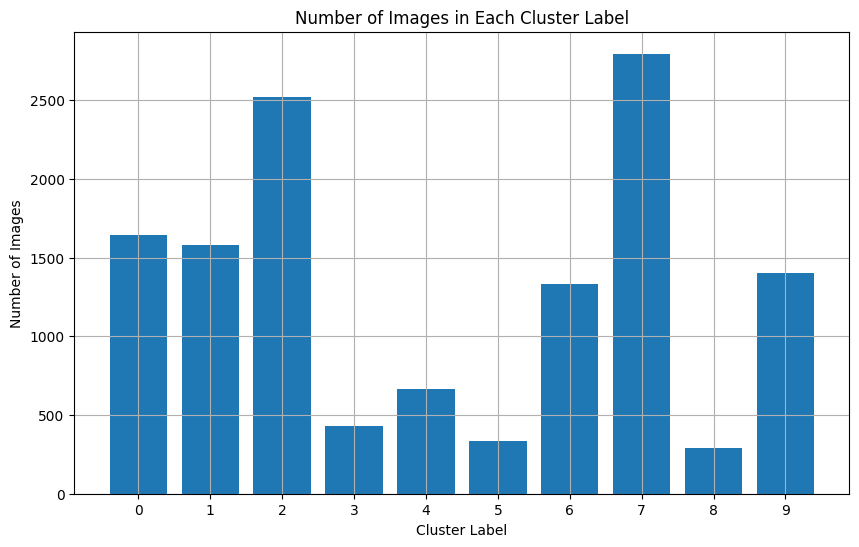

In [59]:
cluster_label_counts = np.zeros(10)
for cluster_id in range(10):
    cluster_label_counts[cluster_id] = np.sum(cluster_ids == cluster_id)

# Plot the number of images in each cluster label
plt.figure(figsize=(10, 6))
plt.bar(range(10), cluster_label_counts, tick_label=range(10))
plt.xlabel('Cluster Label')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Cluster Label')
plt.grid(True)
plt.show()

In [60]:
cluster_buckets = {cluster_id: [] for cluster_id in range(10)}
for i in range(len(dataset.imgs)):
    cluster_buckets[cluster_ids[i]].append((dataset.imgs[i], dataset.labels[i]))

In [61]:
total = 0
for cluster_id, bucket in cluster_buckets.items():
    total += len(bucket)
    print(f'Cluster {cluster_id}: {len(bucket)} images')
print(f'Total: {total} images')

Cluster 0: 1644 images
Cluster 1: 1582 images
Cluster 2: 2517 images
Cluster 3: 433 images
Cluster 4: 667 images
Cluster 5: 337 images
Cluster 6: 1330 images
Cluster 7: 2795 images
Cluster 8: 293 images
Cluster 9: 1402 images
Total: 13000 images
